In [1]:
import Pkg
Pkg.activate(".")

  Activating project at `c:\Users\steal\Downloads\Zero2Hero-JuliaWorkshop-main\BME-502-2025-homeworks`


In [2]:
Pkg.add(["NonlinearSolve","Random","Plots","ForwardDiff","LsqFit","Statistics"])

   Resolving package versions...
  No Changes to `C:\Users\steal\Downloads\Zero2Hero-JuliaWorkshop-main\BME-502-2025-homeworks\Project.toml`
  No Changes to `C:\Users\steal\Downloads\Zero2Hero-JuliaWorkshop-main\BME-502-2025-homeworks\Manifest.toml`


In [3]:
using Plots, Random, ForwardDiff, NonlinearSolve, LsqFit, Statistics 

In [4]:
x = collect(0:0.1:1)

11-element Vector{Float64}:
 0.0
 0.1
 0.2
 0.3
 0.4
 0.5
 0.6
 0.7
 0.8
 0.9
 1.0

In [5]:
y = 2 .* exp.(-2x)

11-element Vector{Float64}:
 2.0
 1.6374615061559636
 1.3406400920712787
 1.097623272188053
 0.8986579282344431
 0.7357588823428847
 0.6023884238244043
 0.493193927883213
 0.40379303598931077
 0.33059777644317306
 0.2706705664732254

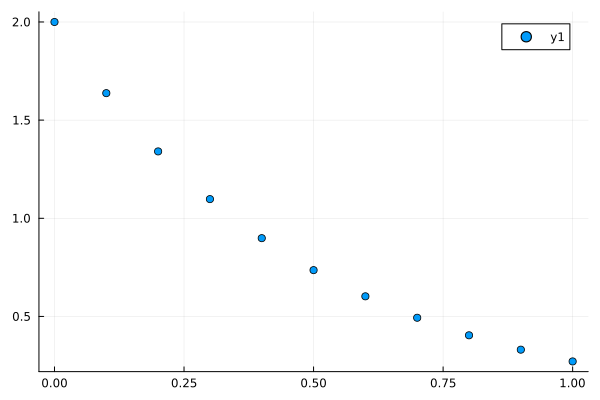

In [6]:
scatter(x,y)

In [7]:
y_exp = y + 0.1*randn(length(y))

11-element Vector{Float64}:
 1.849646049955458
 1.6857386722822638
 1.2572318940459772
 1.1166246868784766
 0.983413804741166
 0.8505840234485093
 0.715295519320897
 0.6444599996030875
 0.35758544962554567
 0.3096965918780228
 0.19220899681251738

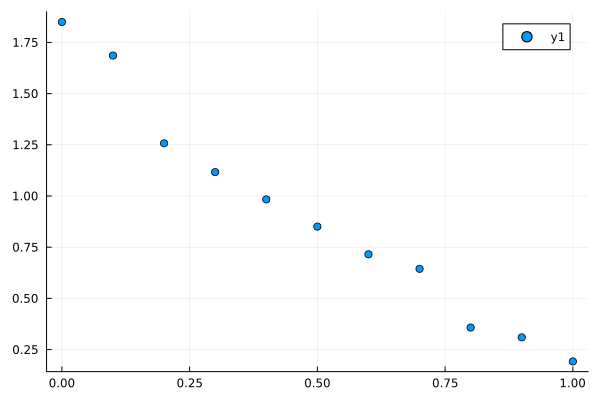

In [8]:
scatter(x,y_exp)

In [9]:
model(x,p) = p[1] .* exp.(-p[2] .* x)

model (generic function with 1 method)

In [10]:
fit = curve_fit(model, x, y_exp, [1.5,1.5])

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}, Vector{LsqFit.LMState{LsqFit.LevenbergMarquardt}}}([1.911299183858863, 1.790754093371114], [0.06165313390340521, -0.0878106523813389, 0.07870440433578363, 0.0002753055533593063, -0.04963755013583193, -0.06990706080811415, -0.0626161253101516, -0.09879205786511858, 0.09861633240229234, 0.07170764686561015, 0.12666129055241318], [0.9999999999959964 0.0; 0.8360428515766374 -0.15979280198250473; … ; 0.19955234740956065 -0.34326381487797913; 0.1668343135682439 -0.31887028737221346], true, Iter     Function value   Gradient norm 
------   --------------   --------------
, Float64[])

In [11]:
fit.param

2-element Vector{Float64}:
 1.911299183858863
 1.790754093371114

In [12]:
cov = estimate_covar(fit)

2×2 Matrix{Float64}:
 0.00437283  0.00496683
 0.00496683  0.0123531

In [13]:
sqrt(estimate_covar(fit))

2×2 Matrix{Float64}:
 0.0589724  0.029918
 0.029918   0.107042

In [14]:
sqrt(cov)


2×2 Matrix{Float64}:
 0.0589724  0.029918
 0.029918   0.107042

In [40]:
function res(u, (x,y))
    return u[1] .* exp.( -u[2] .* x) .- y
end

res (generic function with 1 method)

In [41]:
res([1.5,1.5],(x,y_exp))

11-element Vector{Float64}:
 -0.7047734515522985
 -0.32029896091058174
 -0.17925639873551535
 -0.04393790652448848
 -0.16826254667920737
 -0.1335227501628966
 -0.007497508389405216
  0.06805754461485364
  0.020705836583412796
 -0.190955711992981
 -0.06726976026334303

In [42]:
prob = NonlinearLeastSquaresProblem(res, [1.5,2.0], (x,y_exp))

NonlinearLeastSquaresProblem with uType Vector{Float64}. In-place: false
u0: 2-element Vector{Float64}:
 1.5
 2.0

In [43]:
sol = solve(prob, GaussNewton(); maxiters =1000)

retcode: Stalled
u: 2-element Vector{Float64}:
 2.0463518324401155
 1.9169899663437346

In [44]:
function chi2(u,(x,y))
    sum(res(u,(x,y)) .^2 ./ 0.1^2)
end

chi2 (generic function with 1 method)

In [45]:
chi2(sol.u,(x,y_exp))

13.3496704138807

In [46]:
ourchi2(u) = chi2(u,(x,y_exp))

ourchi2 (generic function with 1 method)

In [25]:
ourchi2(sol.u)

11.542979226703359

In [37]:
h = ForwardDiff.hessian(ourchi2,sol.u)

2×2 Matrix{Float64}:
  618.77   -250.154
 -250.154   216.026

In [39]:
sqrt.(inv(2*h))

2×2 Matrix{Float64}:
 0.0389783  0.0419444
 0.0419444  0.0659683

As an experiment to test that this error estimation method is working, we can repeat the procedure many times and compare the standard deviation of the parameter to the estimation from the Hessian.

In [69]:
function lsqfitting(fitfct, (x,y) , sigma, β0)
    res(β,(x,y)) = fitfct(x,β) .- y
    prob = NonlinearLeastSquaresProblem(res, β0, (x,y))
    sol = solve(prob, GaussNewton(); maxiters =1000)
    chi2(β) = sum(abs2, res(β,(x,y)) ./ sigma)
    return sol.u, inv(2*ForwardDiff.hessian(chi2,sol.u))
end

lsqfitting (generic function with 1 method)

In [67]:
f(x,β) = β[1] .* exp.(-β[2] .* x)

f (generic function with 1 method)

In [71]:
bestbeta, covar = lsqfitting(f, (x,y_exp), 0.1, [1.5,1.5])

([2.0463518329458, 1.916989967594574], [0.001519311444122659 0.001759335652709194; 0.001759335652709194 0.0043518196370285495])

In [75]:
sqrt.(covar)

2×2 Matrix{Float64}:
 0.0389783  0.0419444
 0.0419444  0.0659683